In [ ]:
!pip uninstall torch torchvision torchaudio torchtext torchdata -y
!pip cache purge
!pip install torch==2.0.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torchtext torchdata==0.6.1


import torch
import torchtext

print(f"PyTorch Version: {torch.__version__}")
print(f"TorchText Version: {torchtext.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")



Found existing installation: torch 2.0.1+cu118
Uninstalling torch-2.0.1+cu118:
  Successfully uninstalled torch-2.0.1+cu118
Found existing installation: torchvision 0.15.2+cu118
Uninstalling torchvision-0.15.2+cu118:
  Successfully uninstalled torchvision-0.15.2+cu118
Found existing installation: torchaudio 2.0.2+cu118
Uninstalling torchaudio-2.0.2+cu118:
  Successfully uninstalled torchaudio-2.0.2+cu118
Found existing installation: torchtext 0.15.2
Uninstalling torchtext-0.15.2:
  Successfully uninstalled torchtext-0.15.2
Found existing installation: torchdata 0.6.1
Uninstalling torchdata-0.6.1:
  Successfully uninstalled torchdata-0.6.1
Files removed: 86
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 935.0 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment140


In [ ]:
import numpy as np
import pandas as pd
import re
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


RANDOM_SEED = 3539
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 20000
LEARNING_RATE = 1e-4
BATCH_SIZE = 128
NUM_EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 2


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [ ]:
dataset_path = "/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv"


df = pd.read_csv(dataset_path, encoding="ISO-8859-1", header=None)
df.columns = ["sentiment", "id", "date", "query", "user", "text"]
print(df.head())
print(df.shape)


   sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
(1600000, 6)


# **Data Prepocessing **

In [ ]:
# we only want label and text

df_ = df[["sentiment", "text"]]

#there is only positive and negative tone
print('type of tone',df_['sentiment'].unique())

#we turn 4 into 1 to make it binary
df_.loc[:, "sentiment"] = df_["sentiment"].replace(4, 1)


print(len(df_))
df_sample=df_
# df_sample = df_.sample(n=20000, random_state=RANDOM_SEED)
print(df_sample.head)

type of tone [0 4]
1600000
<bound method NDFrame.head of          sentiment                                               text
0                0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1                0  is upset that he can't update his Facebook by ...
2                0  @Kenichan I dived many times for the ball. Man...
3                0    my whole body feels itchy and like its on fire 
4                0  @nationwideclass no, it's not behaving at all....
...            ...                                                ...
1599995          1  Just woke up. Having no school is the best fee...
1599996          1  TheWDB.com - Very cool to hear old Walt interv...
1599997          1  Are you ready for your MoJo Makeover? Ask me f...
1599998          1  Happy 38th Birthday to my boo of alll time!!! ...
1599999          1  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 2 columns]>


In [ ]:
#def text cleaning function
def clean_text(text):
    text = text.lower()  # 转换为小写
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # remove URL
    text = re.sub(r'\@\w+|\#', '', text)  # remove @ and #
    text = re.sub(r'[^a-zA-Z\s]', '', text)  #only use words
    return text.strip()

df_sample['text'] = df_sample['text'].apply(clean_text)
df_sample.head()

<ipython-input-6-fad821d6abd7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['text'] = df_sample['text'].apply(clean_text)


,sentiment,text
0,0,a thats a bummer you shoulda got david carr o...
1,0,is upset that he cant update his facebook by t...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i her...


In [ ]:
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter

# use tokenizer from torchtext
tokenizer = get_tokenizer("basic_english")


df_sample["tokens"] = df_sample["text"].apply(tokenizer)
df_sample.head()


<ipython-input-7-fe558fd85c28>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample["tokens"] = df_sample["text"].apply(tokenizer)


,sentiment,text,tokens
0,0,a thats a bummer you shoulda got david carr o...,"[a, thats, a, bummer, you, shoulda, got, david..."
1,0,is upset that he cant update his facebook by t...,"[is, upset, that, he, cant, update, his, faceb..."
2,0,i dived many times for the ball managed to sav...,"[i, dived, many, times, for, the, ball, manage..."
3,0,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its..."
4,0,no its not behaving at all im mad why am i her...,"[no, its, not, behaving, at, all, im, mad, why..."


In [ ]:
#create a counter for vocab
counter = Counter()
for tokens in df_sample["tokens"]:
    counter.update(tokens)


#vocab = Vocab(counter, specials=["<PAD>", "<UNK>"], max_size=VOCABULARY_SIZE)
#this not work becausethe version of torchtext, using build_vocab_from_iterator instead

def yield_tokens(data):
    for tokens in data:
        yield tokens

vocab = build_vocab_from_iterator(yield_tokens(df_sample["tokens"]), max_tokens=20000, specials=["<pad>", "<unk>"])
vocab.set_default_index(vocab["<unk>"])


def text_to_indices(text):
    return [vocab[token] for token in text]

df_sample["indices"] = df_sample["tokens"].apply(text_to_indices)


#train,test,valid split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_sample["indices"], df_sample["sentiment"], test_size=0.2, random_state=RANDOM_SEED
)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=RANDOM_SEED
)





<ipython-input-8-ffc8ead6565d>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample["indices"] = df_sample["tokens"].apply(text_to_indices)


In [ ]:
#build dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        """
        Custom dataset for tweets dataset.
        Args:
            texts: List of tokenized text sequences (e.g., token indices)
            labels: List of sentiment labels (0 or 1).
        """
        self.texts = list(texts)  # Convert to list to prevent indexing issues
        self.labels = list(labels)  # Convert to list to prevent indexing issues

    def __len__(self):
        """Return dataset size"""
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Get item by index.
        Returns:
            text_tensor: Tensor of token indices.
            label_tensor: Tensor of the corresponding label.
        """
        text_tensor = torch.tensor(self.texts[idx], dtype=torch.long)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return text_tensor, label_tensor

In [ ]:

train_dataset = SentimentDataset(train_texts, train_labels)
val_dataset = SentimentDataset(val_texts, val_labels)
test_dataset = SentimentDataset(test_texts, test_labels)

#why we do not directly use dataloader?
# NLP tasks, our text data is usually variable-length sequences, but PyTorch's DataLoader does not perform padding by default,
#which can cause shape mismatch errors during model training.

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
    """
    Custom collate function for handling batches of different lengths.
    Args:
        batch: List of (text, label) tuples.
    Returns:
        texts: Padded tensor of token indices.
        labels: Tensor of sentiment labels.
    """
    texts, labels = zip(*batch)
    texts = pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    labels = torch.tensor(labels, dtype=torch.long)
    return texts, labels


PAD_IDX = vocab["<pad>"]


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)





In [ ]:
print('Train')
for batch in train_loader:
    text_batch, label_batch = batch  # Unpack the tuple
    print(f'Text matrix size: {text_batch.size()}')  # (batch_size, seq_length)
    print(f'Target vector size: {label_batch.size()}')  # (batch_size,)
    break

print('\nValid:')
for batch in val_loader:
    text_batch, label_batch = batch  # Unpack the tuple
    print(f'Text matrix size: {text_batch.size()}')  # (batch_size, seq_length)
    print(f'Target vector size: {label_batch.size()}')  # (batch_size,)
    break

print('\nTest:')
for batch in test_loader:
    text_batch, label_batch = batch  # Unpack the tuple
    print(f'Text matrix size: {text_batch.size()}')  # (batch_size, seq_length)
    print(f'Target vector size: {label_batch.size()}')  # (batch_size,)
    break

Train
Text matrix size: torch.Size([128, 29])
Target vector size: torch.Size([128])

Valid:
Text matrix size: torch.Size([128, 30])
Target vector size: torch.Size([128])

Test:
Text matrix size: torch.Size([128, 30])
Target vector size: torch.Size([128])


# Model



In [ ]:
import torch.nn.utils.rnn as rnn_utils  # ✅ Import this at the top of your script

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, padding_idx):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=padding_idx)
        self.layer_norm = nn.LayerNorm(embedding_dim)

        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=2,
                           bidirectional=True, batch_first=True, dropout=0.6)

        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.7) #set high dropout to avoid overfitting

    def forward(self, text, text_length):
        embedded = self.embedding(text)
        embedded = self.layer_norm(embedded)

        text_length = text_length.cpu()
        packed_embedded = rnn_utils.pack_padded_sequence(embedded, text_length, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.batch_norm(hidden)
        hidden = self.dropout(hidden)

        out = self.fc(hidden)
        return out


In [ ]:
from torch.optim import AdamW
INPUT_DIM = len(vocab)

torch.manual_seed(RANDOM_SEED)
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,PAD_IDX)
model = model.to(DEVICE)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)

# Training

In [ ]:
def compute_binary_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for text, labels in data_loader:
            text_lengths = text.ne(PAD_IDX).sum(dim=1)  # Efficient length calculation

            valid_indices = text_lengths > 0 #ensure length is not zero
            if valid_indices.sum() == 0:
                continue

            text, labels = text[valid_indices], labels[valid_indices]
            text_lengths = text_lengths[valid_indices]

            text, labels = text.to(device), labels.to(device)
            text_lengths = text_lengths.cpu()

            logits = model(text, text_lengths)
            predicted_labels = torch.argmax(logits, dim=1)

            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum().item()

    return correct_pred / num_examples * 100 # if num_examples > 0 else 0


In [ ]:
train_accuracies = []
val_accuracies = []
train_losses = []

In [ ]:
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0
    total_batches = 0

    for batch_idx, (text, labels) in enumerate(train_loader):
        text_lengths = text.ne(PAD_IDX).sum(dim=1)
        valid_indices = text_lengths > 0
        if valid_indices.sum() == 0:
            continue

        text, labels = text[valid_indices], labels[valid_indices]
        text_lengths = text_lengths[valid_indices]

        text, labels = text.to(DEVICE), labels.to(DEVICE)
        text_lengths = text_lengths.cpu()

        logits = model(text, text_lengths)
        cost = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        running_loss += cost.item()
        total_batches += 1

        if batch_idx % 1000 == 0:
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                  f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                  f'Cost: {cost:.4f}')

    epoch_loss = running_loss / total_batches
    train_losses.append(epoch_loss)

    with torch.no_grad():
        train_acc = compute_binary_accuracy(model, train_loader, DEVICE)
        val_acc = compute_binary_accuracy(model, val_loader, DEVICE)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f} | Train Acc = {train_acc:.2f}% | Val Acc = {val_acc:.2f}%")


Epoch: 001/010 | Batch 000/8000 | Cost: 0.9075
Epoch: 001/010 | Batch 1000/8000 | Cost: 0.5982
Epoch: 001/010 | Batch 2000/8000 | Cost: 0.5913
Epoch: 001/010 | Batch 3000/8000 | Cost: 0.4058
Epoch: 001/010 | Batch 4000/8000 | Cost: 0.4861
Epoch: 001/010 | Batch 5000/8000 | Cost: 0.5821
Epoch: 001/010 | Batch 6000/8000 | Cost: 0.4857
Epoch: 001/010 | Batch 7000/8000 | Cost: 0.4626
Epoch 1: Loss = 0.5241 | Train Acc = 79.21% | Val Acc = 78.85%
Epoch: 002/010 | Batch 000/8000 | Cost: 0.4630
Epoch: 002/010 | Batch 1000/8000 | Cost: 0.4830
Epoch: 002/010 | Batch 2000/8000 | Cost: 0.5380
Epoch: 002/010 | Batch 3000/8000 | Cost: 0.4129
Epoch: 002/010 | Batch 4000/8000 | Cost: 0.4652
Epoch: 002/010 | Batch 5000/8000 | Cost: 0.3626
Epoch: 002/010 | Batch 6000/8000 | Cost: 0.4324
Epoch: 002/010 | Batch 7000/8000 | Cost: 0.4463
Epoch 2: Loss = 0.4394 | Train Acc = 81.07% | Val Acc = 80.35%
Epoch: 003/010 | Batch 000/8000 | Cost: 0.4447
Epoch: 003/010 | Batch 1000/8000 | Cost: 0.3880
Epoch: 003/01

# Visualization

**learning curve**

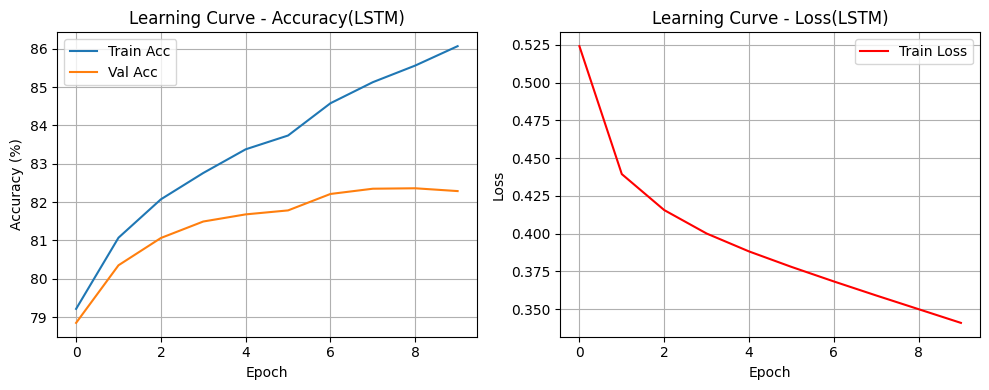

In [30]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Learning Curve - Accuracy(LSTM)")
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve - Loss(LSTM)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**Confusion Matrix**

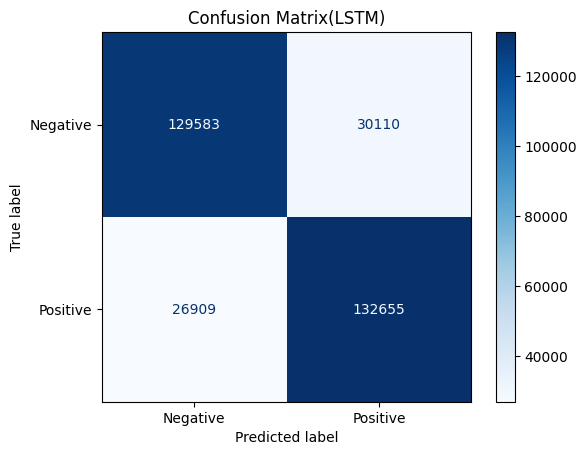

In [31]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def get_preds_and_labels(model, loader):
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for text, labels in loader:
            text_lengths = text.ne(PAD_IDX).sum(dim=1)
            valid_indices = text_lengths > 0
            if valid_indices.sum() == 0:
                continue
            text, labels = text[valid_indices], labels[valid_indices]
            text_lengths = text_lengths[valid_indices].cpu()
            text, labels = text.to(DEVICE), labels.to(DEVICE)

            outputs = model(text, text_lengths)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    return all_preds, all_labels

test_preds, test_labels = get_preds_and_labels(model, test_loader)
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix(LSTM)")
plt.show()

**AUC/ROC**

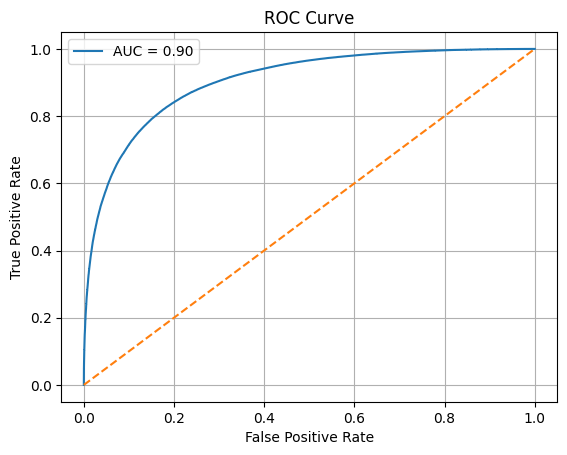

In [ ]:
#AUC/ROC
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F

def get_probs_and_labels(model, loader):
    all_probs, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for text, labels in loader:
            text_lengths = text.ne(PAD_IDX).sum(dim=1)
            valid_indices = text_lengths > 0
            if valid_indices.sum() == 0:
                continue
            text, labels = text[valid_indices], labels[valid_indices]
            text_lengths = text_lengths[valid_indices].cpu()
            text, labels = text.to(DEVICE), labels.to(DEVICE)

            logits = model(text, text_lengths)
            probs = F.softmax(logits, dim=1)[:, 1]

            all_probs.extend(probs.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    return all_probs, all_labels

probs, labels = get_probs_and_labels(model, test_loader)
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve of LSTM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve(LSTM)")
plt.legend()
plt.grid(True)
plt.show()


**Error VS Length**

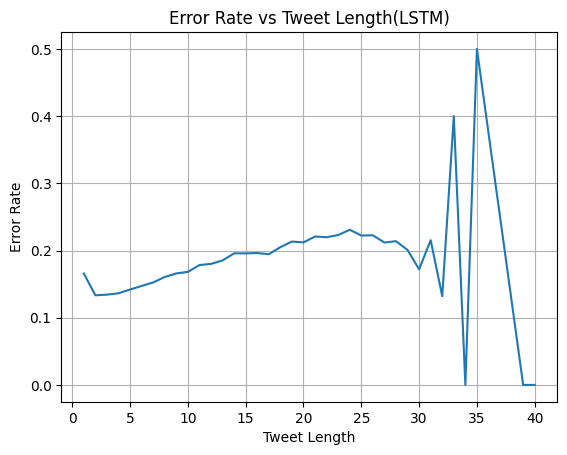

In [32]:
#Error Rate VS Tweet Length
def plot_error_vs_length(model, loader):
    model.eval()
    lengths, errors = [], []

    with torch.no_grad():
        for text, labels in loader:
            text_lengths = text.ne(PAD_IDX).sum(dim=1)

            valid_indices = text_lengths > 0  # <-- avoid length==0
            if valid_indices.sum() == 0:
                continue

            text, labels = text[valid_indices], labels[valid_indices]
            text_lengths = text_lengths[valid_indices].cpu()

            text, labels = text.to(DEVICE), labels.to(DEVICE)
            preds = torch.argmax(model(text, text_lengths), dim=1)
            error = (preds.cpu() != labels.cpu()).int()

            lengths.extend(text_lengths.tolist())
            errors.extend(error.tolist())

    # Plot error rate grouped by tweet length
    import pandas as pd
    df = pd.DataFrame({"length": lengths, "error": errors})
    df_grouped = df.groupby("length").mean()

    df_grouped.plot(y="error", legend=False)
    plt.ylabel("Error Rate")
    plt.xlabel("Tweet Length")
    plt.title("Error Rate vs Tweet Length(LSTM)")
    plt.grid(True)
    plt.show()


plot_error_vs_length(model, test_loader)

**Evaluation Matrix**

In [36]:
#Evaluation Matrix

from sklearn.metrics import classification_report

def evaluate_metrics(model, loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for text, labels in loader:
            text_lengths = text.ne(PAD_IDX).sum(dim=1)
            valid_indices = text_lengths > 0
            if valid_indices.sum() == 0:
                continue
            text, labels = text[valid_indices], labels[valid_indices]
            text_lengths = text_lengths[valid_indices].cpu()
            text, labels = text.to(DEVICE), labels.to(DEVICE)

            logits = model(text, text_lengths)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

evaluate_metrics(model, test_loader)


              precision    recall  f1-score   support

    Negative       0.83      0.81      0.82    159693
    Positive       0.82      0.83      0.82    159564

    accuracy                           0.82    319257
   macro avg       0.82      0.82      0.82    319257
weighted avg       0.82      0.82      0.82    319257

